In [281]:
#ANALYSING BEDFORD BASIN DATA

import rioxarray
import geopandas
from shapely.geometry import mapping

shape_file = geopandas.read_file('/Users/gclyne/sdbcnn/bedford_basin.shp', crs="epsg:4326")
df = rioxarray.open_rasterio('/Users/gclyne/Downloads/products/GeoTIFF/NONNA10_4460N06370W.tiff')
df1 = rioxarray.open_rasterio('/Users/gclyne/Downloads/products/GeoTIFF/NONNA10_4460N06370W.tiff')

df.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
df.rio.write_crs("epsg:4326", inplace=True)
clipped = df.rio.clip([shape_file.geometry.apply(mapping)[0]], shape_file.crs,drop=True)


In [282]:
df1 = rioxarray.open_rasterio('/Users/gclyne/Downloads/products/GeoTIFF/NONNA10_4470N06370W.tiff')
df1.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
df1.rio.write_crs("epsg:4326", inplace=True)
clipped1 = df1.rio.clip([shape_file.geometry.apply(mapping)[0]], shape_file.crs,drop=True)


In [285]:
clipped = clipped.where(clipped!=clipped.rio.nodata)
clipped1 = clipped1.where(clipped1!=clipped1.rio.nodata)

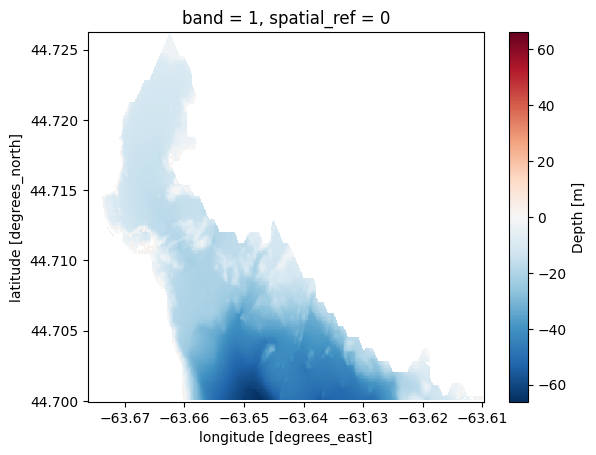

In [279]:
clipped1.isel(band=0).plot()

In [291]:

# clipped.values.size

205821

In [292]:
total_clipped = clipped1.combine_first(clipped)

In [293]:
total_clipped_nan_values = (np.isnan(total_clipped.values)).sum()


In [325]:
total_clipped.values.reshape(1,-1)[0]

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

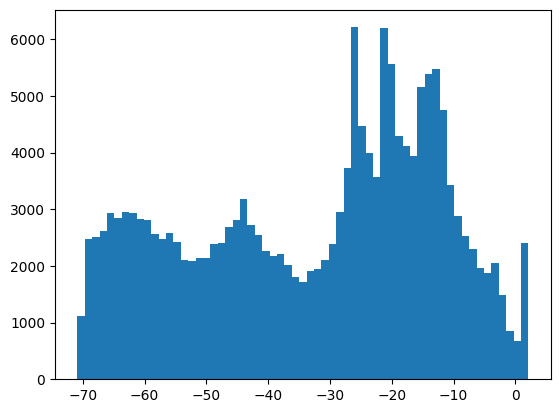

In [298]:
#CLIP OLD DATA FORM ASCII


import pandas as pd

ascii = pd.read_csv('/Users/gclyne/Downloads/products/ASCII/NONNA10_4460N06370W.txt',delimiter='\t')
ascii.columns = ['lat','lon','depth','contributors']

In [299]:
def convert(tude):
    multiplier = 1 if tude[-1] in ['N', 'E'] else -1
    return multiplier * sum(float(x) / 60 ** n for n, x in enumerate(tude[:-1].split('-')))


ascii['lat'] = ascii['lat'].apply(convert)
ascii['lon'] = ascii['lon'].apply(convert)

In [300]:
ascii[['id','CATZOC','TECSOU','start_date','end_date']] = ascii['contributors'].str.split(pat='|',expand=True)

In [301]:
import datetime
ascii['start_date'] = ascii['start_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d'))
ascii['end_date'] = ascii['end_date'].apply(lambda x:datetime.datetime.strptime(x, '%Y%m%d'))
ascii['CATZOC'] = ascii['CATZOC'].apply(lambda x: int(x))

In [302]:
min_viable_date = datetime.datetime.strptime('2000','%Y')
to_remove = ascii[(ascii['start_date'] < min_viable_date) | (ascii.CATZOC == 4) | (ascii.CATZOC == 5) | (ascii.CATZOC == 6)]


In [303]:
ascii[ascii.CATZOC == 5]

lats = to_remove['lat'].to_list()
lons = to_remove['lon'].to_list()
lons = list(map(lambda x: round(x,4),lons))
lats = list(map(lambda x: round(x,4),lats))

In [345]:
ascii['start_date'].unique()

array(['2014-03-24T00:00:00.000000000', '2005-01-06T00:00:00.000000000',
       '1998-12-08T00:00:00.000000000', '2014-10-30T00:00:00.000000000',
       '2016-02-29T00:00:00.000000000', '1958-01-01T00:00:00.000000000',
       '1998-04-14T00:00:00.000000000', '1998-12-12T00:00:00.000000000',
       '2004-04-07T00:00:00.000000000', '2014-06-01T00:00:00.000000000',
       '2021-06-02T00:00:00.000000000', '2017-02-21T00:00:00.000000000',
       '2011-11-30T00:00:00.000000000', '2013-06-05T00:00:00.000000000',
       '2015-04-08T00:00:00.000000000', '2014-09-30T00:00:00.000000000',
       '2012-12-17T00:00:00.000000000', '2020-10-19T00:00:00.000000000',
       '2020-08-11T00:00:00.000000000', '2008-09-04T00:00:00.000000000',
       '2019-12-06T00:00:00.000000000', '2021-09-23T00:00:00.000000000',
       '1987-05-08T00:00:00.000000000', '1999-01-05T00:00:00.000000000'],
      dtype='datetime64[ns]')

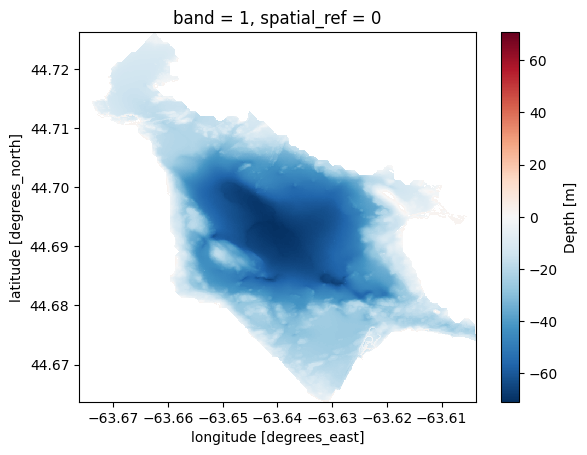

In [304]:
total_clipped.plot()

In [335]:
import numpy as np
# total_clipped.values.where(tota l_clipped==np.nan).sum()
total_clipped_old_removed = clipped.where(~(clipped.x.isin(lons) & clipped.y.isin(lats)))

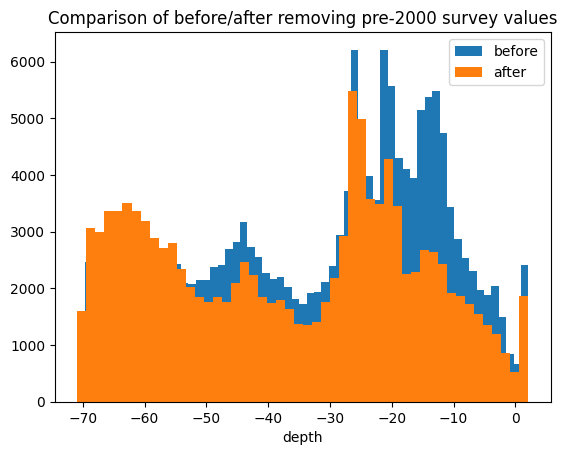

In [343]:
import matplotlib.pyplot as plt
plt.hist(total_clipped.values.reshape(1,-1)[0],bins='auto')
plt.hist(total_clipped_old_removed.values.reshape(1,-1)[0],bins='auto')
plt.title('Comparison of before/after removing pre-2000 survey values')
plt.legend(['before','after'])
plt.xlabel('depth')
plt.show()